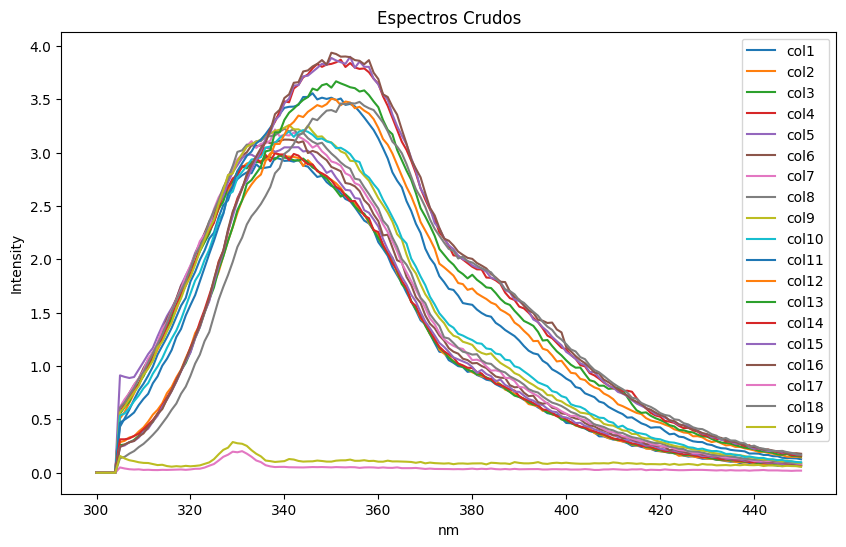

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# Read the CSV file with specified column names
df = pd.read_csv('espectros_crudos.csv', sep=';', decimal=',', names=['nm'] + [f'col{i}' for i in range(1, 20)])

# Convert the 'nm' column to a numeric type
df['nm'] = pd.to_numeric(df['nm'], errors='coerce')

#print(df.dtypes)
#print(df)

# Plot the data
plt.figure(figsize=(10,6))
for column in df.columns[1:]:
    plt.plot(df['nm'], pd.to_numeric(df[column]), label=column)

plt.xlabel('nm')
plt.ylabel('Intensity')
plt.title('Espectros Crudos')
plt.legend()
plt.show()

In [2]:
blanco = df.iloc[:, 17]

new_df = df.copy()
new_df.loc[:, 'col1':'col19'] = df.loc[:, 'col1':'col19'].apply(lambda x: blanco - x)
new_df.to_csv('sin_blanco.csv', index=False)


# Sumatoria de valores de columna de 310-420 nm sin blanco
sum_values = new_df.loc[:, 'col1':'col19'].iloc[11:122].sum()
#print(sum_values.iloc[0:3])

# Multiplicacion de valores de columna de 310-420 nm sin blanco por el nm
mult_values = new_df.loc[:, 'col1':'col19'].iloc[11:122].mul(new_df['nm'], axis=0)
#print(mult_values.iloc[0:3])

# Sumatoria de valores de columna de 310-420 nm sin blanco multiplicado por el nm
sum_mult_values = mult_values.loc[:, 'col1':'col19'].iloc[11:122].sum()
#print(sum_mult_values.iloc[0:3])

    ClGdn (M)      I355  I(310-420)          CM
0        0.00  2.437441  161.799629  349.822039
1        0.50  2.469790  165.343003  349.582818
2        1.50  2.443850  165.259994  349.558565
3        2.40  2.496030  166.448970  349.656500
4        3.20  2.523191  171.654081  349.654206
5        3.60  2.633360  175.965879  350.098205
6        3.80  2.662351  179.379594  350.390970
7        4.00  2.704770  182.122230  350.766790
8        4.15  2.868040  186.772795  351.670503
9        4.30  2.875370  184.975897  352.965896
10       4.60  3.382261  208.790889  355.250241
11       5.00  3.365171  204.645662  358.040077
12       5.25  3.552860  214.036884  358.720271
13       5.50  3.746951  226.222242  358.960652
14       5.80  3.743590  226.632380  359.084791
15       6.00  3.816221  229.996003  359.231457


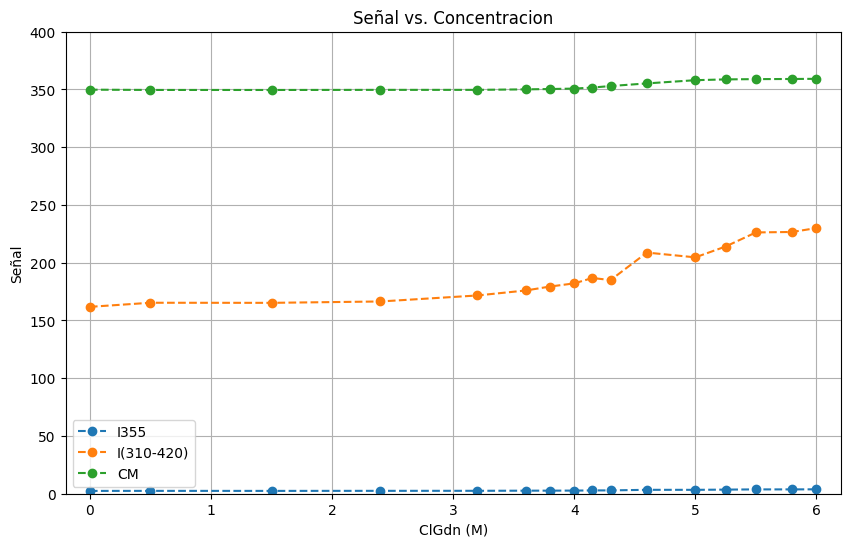

In [3]:
import numpy as np

concentrations = pd.DataFrame([0, 0.5, 1.5, 2.4, 3.2, 3.6, 3.8, 4, 4.15, 4.3, 4.6, 5, 5.25, 5.5, 5.8, 6], columns=['ClGdn (M)'])
#print(concentrations)
I355_values = pd.DataFrame(np.transpose(new_df.loc[new_df['nm'] == 355, 'col1':'col16'].values*-1), columns=['I355'])
#print(I355_values)
sum_values = pd.DataFrame(np.transpose(new_df.loc[:, 'col1':'col16'].iloc[11:122].sum().values*-1), columns=['I(310-420)'])
#print(sum_values)

sum_mult_values = pd.DataFrame(mult_values.loc[:, 'col1':'col16'].iloc[11:122].sum().values, columns=['I-Blanco x nm'])
CM = sum_mult_values.div(sum_values['I(310-420)']*-1, axis=0).rename(columns={'I-Blanco x nm': 'CM'})
#print(CM)

combined_df = pd.concat([concentrations, I355_values, sum_values, CM], axis=1)
print(combined_df)


plt.figure(figsize=(10, 6))

for column in ['I355', 'I(310-420)', 'CM']:
    plt.plot(combined_df['ClGdn (M)'], combined_df[column], marker='o', linestyle='--', label=column)

plt.xlabel('ClGdn (M)')
plt.ylabel('Señal')
plt.xlim(-0.2, 6.2)
plt.ylim(0, 400)
plt.title('Señal vs. Concentracion')
plt.grid(True)
plt.legend() 
plt.show()

In [4]:
combined_df = pd.concat([concentrations, I355_values, sum_values, CM], axis=1)
R_cte = 1.987
T_cte = 293

'''PRIMER GRAFICO'''
# Distinguir los puntos
Puntos_IU = 5
Puntos_IN = 5

x_IU_de_ITotal = combined_df['ClGdn (M)'].iloc[-Puntos_IU:]
y_IU_de_ITotal = combined_df['I(310-420)'].iloc[-Puntos_IU:]

x_IN_de_ITotal = combined_df['ClGdn (M)'].iloc[1:Puntos_IN]
y_IN_de_ITotal = combined_df['I(310-420)'].iloc[1:Puntos_IN]


# Regresion lineal de cada conjunto
z_IU = np.polyfit(x_IU_de_ITotal, y_IU_de_ITotal, 1)
p_IU = np.poly1d(z_IU)

z_IN = np.polyfit(x_IN_de_ITotal, y_IN_de_ITotal, 1)
p_IN = np.poly1d(z_IN)


'''SEGUNDO GRAFICO'''
# Fracciones calculadas de IU e IN a partir de I(310-420)
ITotal_df = pd.DataFrame({
    'IU (310-420)': p_IU(combined_df['ClGdn (M)']),
    'IN (310-420)': p_IN(combined_df['ClGdn (M)'])
})

ITotal_df['fu (310-420)'] = (combined_df['I(310-420)'] - ITotal_df['IN (310-420)']) / (ITotal_df['IU (310-420)'] - ITotal_df['IN (310-420)'])


'''TERCER GRAFICO'''
ITotal_df['Ku (310-420)'] = ITotal_df['fu (310-420)'] / (1 - ITotal_df['fu (310-420)'])
ITotal_df['Gu (310-420)'] = R_cte * T_cte * -np.log(ITotal_df['Ku (310-420)']) 
print(ITotal_df)


    IU (310-420)  IN (310-420)  fu (310-420)  Ku (310-420)  Gu (310-420)
0      83.905978    163.062690      0.015956      0.016215   2399.678634
1      96.283533    164.145275     -0.017650     -0.017343           NaN
2     121.038643    166.310444      0.023203      0.023754   2177.387896
3     143.318242    168.259097      0.072577      0.078256   1483.285892
4     163.122330    169.991233     -0.242084     -0.194901           NaN
5     173.024374    170.857300      2.357363     -1.736723           NaN
6     177.975396    171.290334      1.210050     -5.760768           NaN
7     182.926418    171.723368      0.928217     12.930885  -1490.186941
8     186.639685    172.048144      1.009122   -110.619721           NaN
9     190.352951    172.372919      0.700943      2.343844   -495.905928
10    197.779484    173.022470      1.444779     -3.248307           NaN
11    207.681528    173.888538      0.910163     10.131252  -1348.135985
12    213.870306    174.429830      1.004224   -237

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Regresion IU:  
24.76 x + 83.91
Regresion IN:  
2.165 x + 163.1


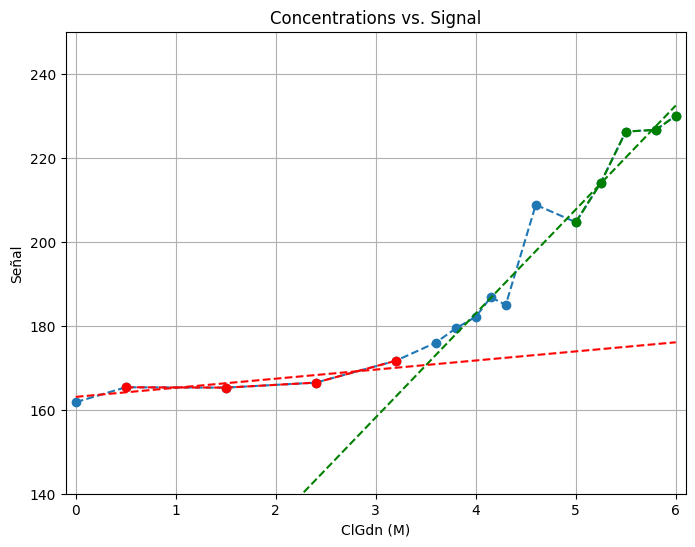

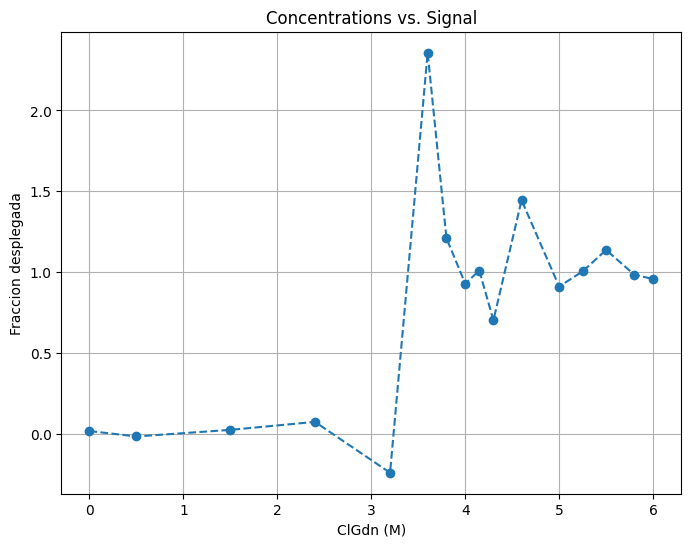

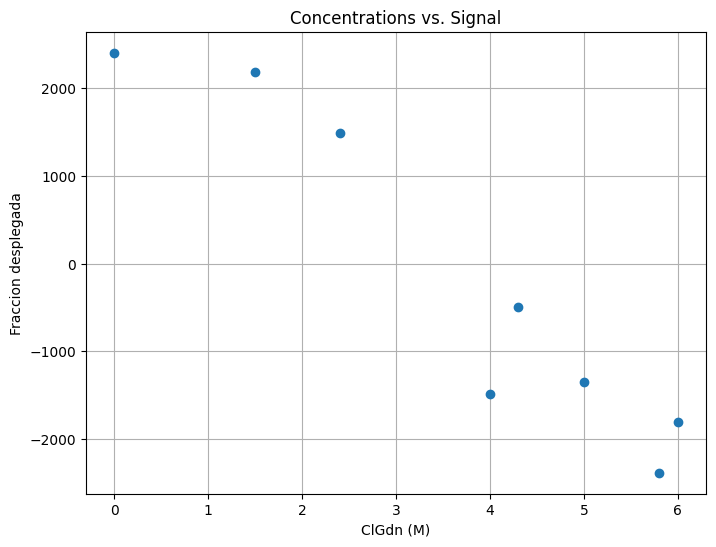

In [5]:
print(f'Regresion IU: {p_IU}')
print(f'Regresion IN: {p_IN}')

# Plot the original data
plt.figure(figsize=(8, 6))
plt.plot(combined_df['ClGdn (M)'], combined_df['I(310-420)'], marker='o', linestyle='--')

# Plot the regression points
plt.plot(x_IU_de_ITotal, y_IU_de_ITotal, marker='o', linestyle='--', color='green')
plt.plot(x_IN_de_ITotal, y_IN_de_ITotal, marker='o', linestyle='--', color='red')

# Plot the linear regression line
xp_IU = np.linspace(0, 6, 100)
plt.plot(xp_IU, p_IU(xp_IU), color='green', linestyle='--')

xp_IN = np.linspace(0, 6, 100)
plt.plot(xp_IN, p_IN(xp_IN), color='red', linestyle='--')

plt.xlabel('ClGdn (M)')
plt.ylabel('Señal')
plt.xlim(-0.1, 6.1)
plt.ylim(140, 250)
plt.title('Concentrations vs. Signal')
plt.grid(True)
plt.show()



# Plot the original data
plt.figure(figsize=(8, 6))
plt.plot(combined_df['ClGdn (M)'], ITotal_df['fu (310-420)'], marker='o', linestyle='--')
plt.xlabel('ClGdn (M)')
plt.ylabel('Fraccion desplegada')
#plt.xlim(-0.1, 6.1)
#plt.ylim(140, 250)
plt.title('Concentrations vs. Signal')
plt.grid(True)
plt.show()

# Plot the original data
plt.figure(figsize=(8, 6))
plt.plot(combined_df['ClGdn (M)'], ITotal_df['Gu (310-420)'], marker='o', linestyle='')
plt.xlabel('ClGdn (M)')
plt.ylabel('Fraccion desplegada')
#plt.xlim(-0.1, 6.1)
#plt.ylim(140, 250)
plt.title('Concentrations vs. Signal')
plt.grid(True)
plt.show()



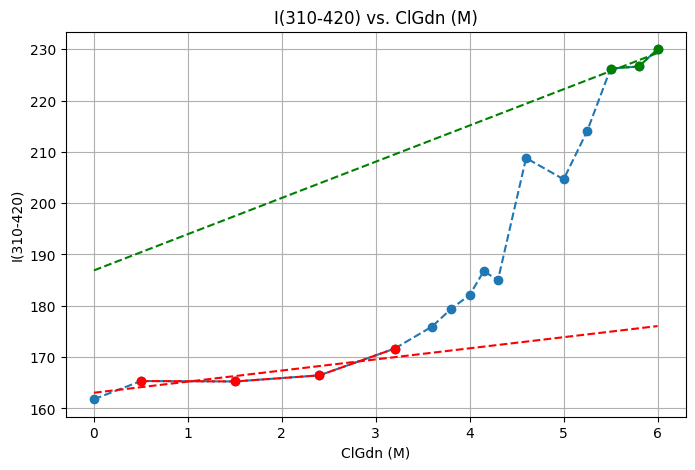

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


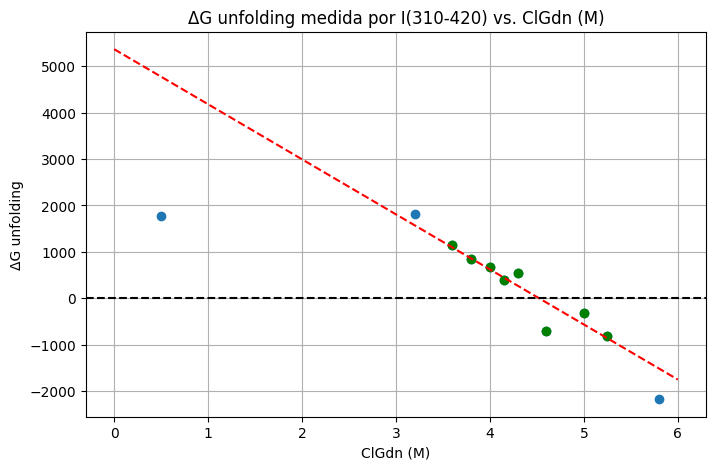

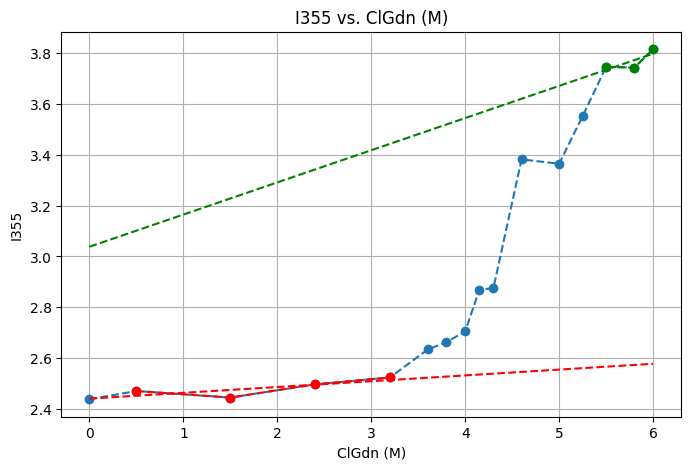

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


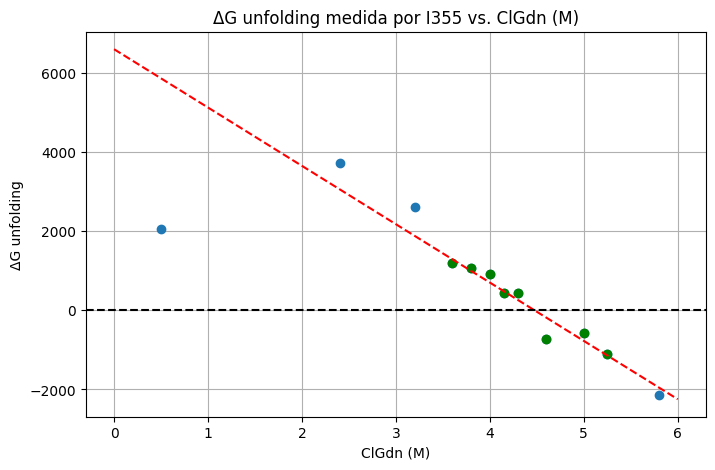

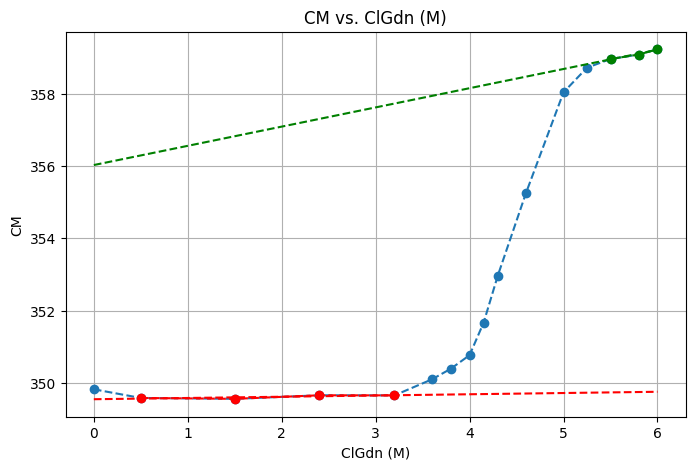

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


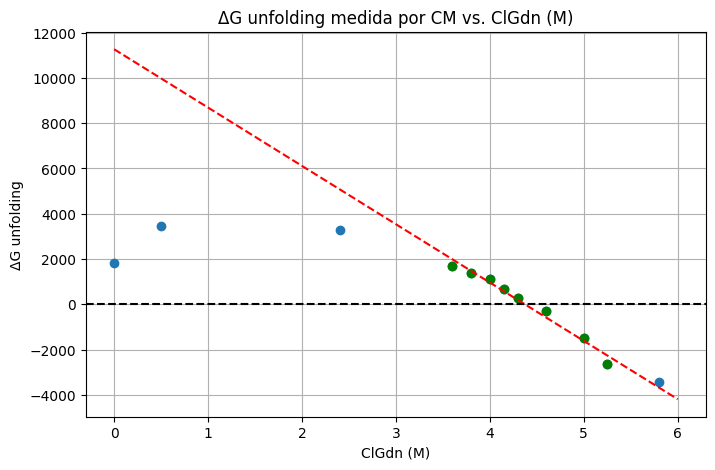

In [6]:
from sklearn.metrics import r2_score
# Distinguir los puntos
Puntos_IU = 3
Puntos_IN = 5
figura=(8, 5)

for column in ['I(310-420)', 'I355', 'CM']:
    x_IU = combined_df['ClGdn (M)'].iloc[-Puntos_IU:]
    y_IU = combined_df[column].iloc[-Puntos_IU:]

    x_IN = combined_df['ClGdn (M)'].iloc[1:Puntos_IN]
    y_IN = combined_df[column].iloc[1:Puntos_IN]

    # Regresion lineal de cada conjunto
    z_IU = np.polyfit(x_IU, y_IU, 1)
    p_IU = np.poly1d(z_IU)    
    #R2_IU = r2_score(y_IU, p_IU(x_IU))

    z_IN = np.polyfit(x_IN, y_IN, 1)
    p_IN = np.poly1d(z_IN)
    #R2_IN = r2_score(y_IN, p_IN(x_IN))

    # print(f'Regresion IU: {p_IU}')
    # print("R2_IU:", R2_IU)
    # print(f'Regresion IN: {p_IN}')
    # print("R2_IN:", R2_IN)

    # Plot the original data
    plt.figure(figsize=figura)
    plt.plot(combined_df['ClGdn (M)'], combined_df[column], marker='o', linestyle='--')

    # Plot the regression points
    plt.plot(x_IU, y_IU, marker='o', linestyle='--', color='green')
    plt.plot(x_IN, y_IN, marker='o', linestyle='--', color='red')

    # Plot the linear regression line
    xp_IU = np.linspace(0, 6, 100)
    plt.plot(xp_IU, p_IU(xp_IU), color='green', linestyle='--')

    xp_IN = np.linspace(0, 6, 100)
    plt.plot(xp_IN, p_IN(xp_IN), color='red', linestyle='--')

    plt.xlabel('ClGdn (M)')
    plt.ylabel(column)
    plt.title(column+' vs. ClGdn (M)')
    plt.grid(True)
    plt.show()

    '''SEGUNDO GRAFICO'''    
    # Fracciones calculadas de IU e IN
    ITotal_df = pd.DataFrame({
    'IU_'+column: p_IU(combined_df['ClGdn (M)']),
    'IN_'+column: p_IN(combined_df['ClGdn (M)'])
    })

    # Fracciones desplegadas
    ITotal_df['fu_'+column] = (combined_df[column] - ITotal_df['IN_'+column]) / (ITotal_df['IU_'+column] - ITotal_df['IN_'+column])
    #print(ITotal_df)
    
    # plt.figure(figsize=figura)
    # plt.plot(combined_df['ClGdn (M)'], ITotal_df['fu_'+column], marker='o', linestyle='--')
    # plt.xlabel('ClGdn (M)')
    # plt.ylabel('Fraccion desplegada')
    # plt.title('Fraccion desplegada medida por '+column+ ' vs. ClGdn (M)')
    # plt.grid(True)
    # plt.show()

    
    '''TERCER GRAFICO'''
    ITotal_df['Ku_'+column] = ITotal_df['fu_'+column] / (1 - ITotal_df['fu_'+column])
    ITotal_df['Gu_'+column] = -R_cte * T_cte * np.log(ITotal_df['Ku_'+column]) 
    #print(ITotal_df)
    
    plt.figure(figsize=figura)
    plt.plot(combined_df['ClGdn (M)'], ITotal_df['Gu_'+column], marker='o', linestyle='')
    
    # Regresion lineal
    x_IT = combined_df['ClGdn (M)'].iloc[Puntos_IN:len(combined_df['ClGdn (M)'])-Puntos_IU]
    y_IT = ITotal_df['Gu_'+column].iloc[Puntos_IN:len(combined_df['ClGdn (M)'])-Puntos_IU]
    plt.plot(x_IT, y_IT, marker='o', linestyle='', color='green')
    
    z_IT = np.polyfit(x_IT, y_IT, 1)
    p_IT = np.poly1d(z_IT)

    xp_IT = np.linspace(0, 6, 100)
    plt.plot(xp_IT, p_IT(xp_IT), linestyle='--', color='red')

    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('ClGdn (M)')
    plt.ylabel('ΔG unfolding')
    plt.title('ΔG unfolding medida por '+column+ ' vs. ClGdn (M)')
    plt.grid(True)
    plt.show()